In [49]:
NET = 'dilation'

In [50]:
import tensorflow as tf
import datasets
import pickle
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

if NET == 'dilation':
    import experiments.dilation as experiments
elif NET == 'lstm':
    import experiments.lstm as experiments
elif NET == 'coloring':
    import experiments.coloring as experiments
elif NET == 'crossing':
    import experiments.crossing as experiments
elif NET == 'unet':
    import experiments.unet as experiments
elif NET == 'multi_lstm':
    import experiments.multi_lstm as experiments
elif NET == 'FF':
    import experiments.FF as experiments

In [51]:
output_path = '/om/user/xboix/share/insideness/' + NET + '/'
run_opt = experiments.get_experiments(output_path)[1:]
len(run_opt)

4861


6318

In [52]:
results_data = []
for opt in run_opt:
    data_point = {}
    data_point["C"] = 0 #opt.hyper.complex_crossing
    data_point["alpha"] =  opt.hyper.alpha
    data_point["init_factor"] = opt.hyper.init_factor
    data_point["learning_rate"] = opt.hyper.learning_rate
    data_point["batch_size"] = opt.hyper.batch_size
    
    if NET == 'dilation':
        data_point["num_layer"] = opt.dnn.num_layers
        data_point["complex_dilation"] = opt.dnn.complex_dilation
    
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
    
    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl'):
        data_point["results"] = "empty"
       
    else:
        with open(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data.append(copy.deepcopy(data_point))


In [53]:
NUM_COMPLEXITIES = 6 

max_val_acc = -np.ones([2, NUM_COMPLEXITIES])
max_idx = np.zeros([2, NUM_COMPLEXITIES])
missing = np.zeros([2, NUM_COMPLEXITIES])

for point_idx, data_point in enumerate(results_data):

    point_complextity = data_point["dataset_complexity"]
    idx_strict = 1-int(data_point["dataset_strict_complexity"])
    
    #if (not ("val" in data_point["results"])):
    #    print(point_idx)
    
    if not (data_point["results"] == "empty") and ("val" in data_point["results"]): 
        
            if max_val_acc[idx_strict, point_complextity] < data_point["results"]["valloose"]:
                max_idx[idx_strict, point_complextity] = point_idx
                max_val_acc[idx_strict, point_complextity] = data_point["results"]["valloose"]
    
    else:
        missing[idx_strict, point_complextity] += 1
        
print(max_idx)

max_train = np.zeros([2, NUM_COMPLEXITIES])
max_test = np.zeros([2, NUM_COMPLEXITIES])
max_train_loose = np.zeros([2, NUM_COMPLEXITIES])
max_test_loose = np.zeros([2, NUM_COMPLEXITIES])

C = np.zeros([2, NUM_COMPLEXITIES])
alpha =  np.zeros([2, NUM_COMPLEXITIES])
init_factor = np.zeros([2, NUM_COMPLEXITIES])
learning_rate = np.zeros([2, NUM_COMPLEXITIES])
batch_size = np.zeros([2, NUM_COMPLEXITIES])
num_layer = np.zeros([2, NUM_COMPLEXITIES])
complex_dilation = np.zeros([2, NUM_COMPLEXITIES])
for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
    for dataset_complexity in range(NUM_COMPLEXITIES):
        max_train[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["train"]
        max_test[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["test"]
        max_train_loose[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["trainloose"]
        max_test_loose[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["testloose"]
        
        C[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["C"]
        alpha[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["alpha"]
        init_factor[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["init_factor"]
        learning_rate[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["learning_rate"]
        batch_size[idx_strict, dataset_complexity] = \
            results_data[int(max_idx[idx_strict,dataset_complexity])]["batch_size"]
        
        if NET == 'dilation':
            num_layer[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["num_layer"]
            complex_dilation[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["complex_dilation"]

        

[[ 703. 1909. 2539. 3691. 4645. 5329.]
 [  55. 1045. 2233. 3205. 4159.    0.]]


[100.         100.          99.96421354  99.9705288   99.80422701
  99.98421186]
[99.98000168 99.9410576  99.95053048 99.84843382 99.27479791 99.28742843]
[99.99894746 99.98736948 99.99789491 99.9926322  99.90211351  0.        ]
[100.          99.93053217  99.96947625  99.9410576   99.85580162
   0.        ]
[100.         100.          99.99997857  99.99998398  99.99987511
  99.99998772]
[99.99989197 99.99996615 99.99993829 99.99984729 99.99866073 99.99882813]
[99.99999947 99.99999172 99.99999887 99.99999562 99.99992896 50.        ]
[100.          99.9999411   99.9999818   99.99995719  99.99983416
  50.        ]
[ 18.  18.  18.  18.  18. 840.]
[18. 18. 21. 18. 18.  0.]


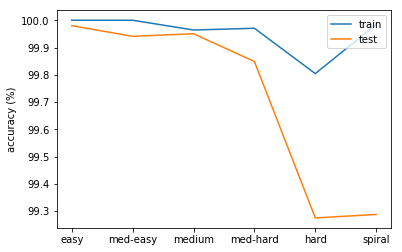

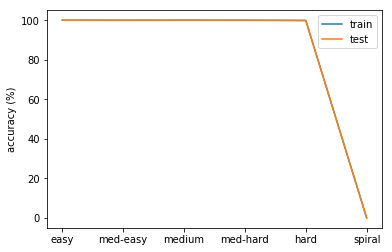

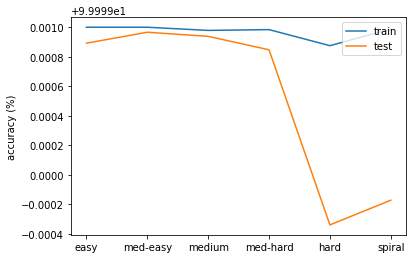

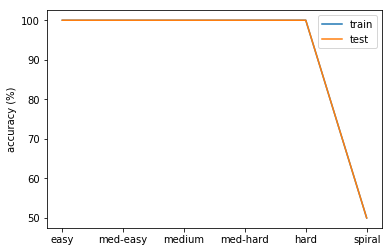

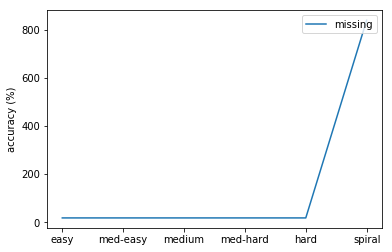

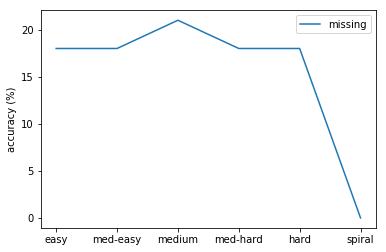

In [54]:
def plot_results_train_test(train, title, fig, name):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['easy','med-easy','medium','med-hard','hard', 'spiral' ]
    ytext ='accuracy (%)'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, label=name)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='upper right', ncol=1,  fancybox=True)

plot_results_train_test(100*max_train[0,:], "Exclusive Complexity", 1, 'train')
plot_results_train_test(100*max_test[0,:], "Exclusive Complexity", 1, 'test')

plot_results_train_test(100*max_train[1,:], "Mixed Complexity", 2, 'train')
plot_results_train_test(100*max_test[1,:], "Mixed Complexity", 2, 'test')

plot_results_train_test(100*max_train_loose[0,:], "Loose Acc - Exclusive Complexity", 3, 'train')
plot_results_train_test(100*max_test_loose[0,:], "Loose Acc - Exclusive Complexity", 3, 'test')

plot_results_train_test(100*max_train_loose[1,:], "Loose Acc - Mixed Complexity", 4, 'train')
plot_results_train_test(100*max_test_loose[1,:], "Loose Acc - Mixed Complexity", 4, 'test')    

plot_results_train_test(missing[0,:], "Exclusive Complexity", 5, 'missing')
plot_results_train_test(missing[1,:], "Mixed Complexity", 6, 'missing')


In [ ]:
def plot_results(data, title, fig):

    x = np.linspace(1,5, 5)
    xlabels = ['easy','med-easy','medium','med-hard','hard' ]
    ytext ='accuracy (%)'

    plt.figure(fig)
    plt.plot(x, data, label="train")
    plt.title(title)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='upper right', ncol=1,  fancybox=True)

plot_results(C[0,:], "C - Exclusive Complexity", 1)
plot_results(C[1,:], "C - Mixed Complexity", 2)
plot_results(alpha[0,:], "alpha - Exclusive Complexity", 3)
plot_results(alpha[1,:], "alpha - Mixed Complexity", 4)    
plot_results(init_factor[0,:], "init_factor - Exclusive Complexity", 5)
plot_results(init_factor[1,:], "init_factor - Mixed Complexity", 6)   
plot_results(learning_rate[0,:], "learning_rate - Exclusive Complexity", 7)
plot_results(learning_rate[1,:], "learning_rate - Mixed Complexity", 8)  
plot_results(batch_size[0,:], "batch_size - Exclusive Complexity", 9)
plot_results(batch_size[1,:], "batch_size - Mixed Complexity", 10)  
if NET == 'dilation':
    plot_results(num_layer[0,:], "num_layer - Exclusive Complexity", 11)
    plot_results(num_layer[1,:], "num_layer - Mixed Complexity", 12) 
    plot_results(complex_dilation[0,:], "complex_dilation - Exclusive Complexity", 13)
    plot_results(complex_dilation[1,:], "complex_dilation - Mixed Complexity", 14) 

In [ ]:

missing = np.zeros([2, 5])

C = [3,5,7,9,11]#[5, 10, 20, 40, 80]#
alpha = [0.1, 0.2, 0.4]
init_factor = [1, 1e-1, 1e1]
batch_size = [32, 256, 2048]
learning_rate = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for c in alpha:
    max_val_acc = np.zeros([2, 5])
    max_idx = -np.ones([2, 5])
    for point_idx, data_point in enumerate(results_data):

        point_complextity = data_point["dataset_complexity"]
        idx_strict = 1-int(data_point["dataset_strict_complexity"])

        #if (not ("val" in data_point["results"])):
        #    print(point_idx)

        if (data_point["alpha"] == c) and not (data_point["results"] == "empty") and ("val" in data_point["results"]): 

                if max_val_acc[idx_strict, point_complextity] < data_point["results"]["valloose"]:
                    max_idx[idx_strict, point_complextity] = point_idx
                    max_val_acc[idx_strict, point_complextity] = data_point["results"]["valloose"]

        else:
            missing[idx_strict, point_complextity] += 1

    max_train = np.zeros([2, 5])
    max_test = np.zeros([2, 5])
    max_train_loose = np.zeros([2, 5])
    max_test_loose = np.zeros([2, 5])
    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(5):
            max_train[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["train"]
            max_test[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["test"]
            max_train_loose[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["trainloose"]
            max_test_loose[idx_strict, dataset_complexity] = \
                results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]["testloose"]
            
    plot_results_train_test(100*max_train[0,:], "Exclusive Complexity", 1, "C="+str(c))
    #plot_results_train_test(100*max_train[1,:], "Mixed Complexity", 2, "C="+str(c))
    plot_results_train_test(100*max_train_loose[0,:], "Loose Acc - Exclusive Complexity", 3, "C="+str(c))
    #plot_results_train_test(100*max_train_loose[1,:], "Loose Acc - Mixed Complexity", 4, "C="+str(c))    

In [ ]:
output_path = '/om/user/xboix/share/insideness/' + NET + '/'
run_opt = experiments.get_best_of_the_family(output_path)
opt_data = datasets.get_datasets(output_path)

In [ ]:
results_data_generalization = []
for opt in run_opt:
    data_point = {}
    data_point["C"] = 0 #opt.hyper.complex_crossing
    data_point["alpha"] =  opt.hyper.alpha
    data_point["init_factor"] = opt.hyper.init_factor
    data_point["learning_rate"] = opt.hyper.learning_rate
    data_point["batch_size"] = opt.hyper.batch_size
    
    if NET == 'dilation':
        data_point["num_layer"] = opt.dnn.num_layers
        data_point["complex_dilation"] = opt.dnn.complex_dilation
        
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
    
    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl'):
        data_point["results"] = "empty"
        print('EMPTY')
    else:
        with open(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data_generalization.append(copy.deepcopy(data_point))
    
datasets_idx = np.zeros([2,NUM_COMPLEXITIES])
for idx, opt in enumerate(opt_data):
    if not opt.num_images_training == 1e5:
        continue
    if opt.complexity_strict:
        datasets_idx[0,opt.complexity] = idx
    else:
        datasets_idx[1,opt.complexity] = idx

results_data_generalization

In [ ]:
dataset_labels = ['easy','med-easy','medium','med-hard','hard', 'spiral' ]
#fontbf = FontProperties()
#fontbf.set_weight('bold')

def plot_results_generalization(train, title, fig, name):
    x = np.linspace(1,NUM_COMPLEXITIES, NUM_COMPLEXITIES)
    xlabels = dataset_labels
    ytext = r'Accuracy (%)'
    xtext = r'$\bf Test$ $\bf Set$'
    
    plt.figure(fig)
    #print(train)
    plt.plot(x, train, label=name)
    plt.title(title)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    plt.xlabel(xtext)
    leg = plt.legend(loc='upper right', ncol=1,  title=r'$\bf Train$ $\bf Set$', fancybox=True)

for res in results_data_generalization:
    
    #Collect all generalization results for one network
    test = np.zeros([2, NUM_COMPLEXITIES])
    test_loose = np.zeros([2, NUM_COMPLEXITIES])
    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(NUM_COMPLEXITIES):
            test[idx_strict, dataset_complexity] = \
                res["results"]["test_accuracy"][int(datasets_idx[idx_strict,dataset_complexity])]
            test_loose[idx_strict, dataset_complexity] = \
                res["results"]["test_accuracy_loose"][int(datasets_idx[idx_strict,dataset_complexity])]
            
    if res['dataset_strict_complexity']:
        plot_results_generalization(100*test[0,:], "Exclusive Complexity", 0, dataset_labels[res['dataset_complexity']])
        plot_results_generalization(100*test_loose[0,:], "Exclusive Complexity - Loose Acc", 2, dataset_labels[res['dataset_complexity']])
    else:
        plot_results_generalization(100*test[0,:], "Mixed Complexity", 1, dataset_labels[res['dataset_complexity']])
        plot_results_generalization(100*test_loose[0,:], "Mixed Complexity - Loose Acc", 3, dataset_labels[res['dataset_complexity']])
        
        

In [ ]:
output_path = '/om/user/xboix/share/insideness/' + NET + '/'
run_opt = experiments.get_experiments_selected(output_path)

In [ ]:
results_data_initial_conditions = []
for opt in run_opt:
    data_point = {}
    data_point["C"] = 0 #opt.hyper.complex_crossing
    data_point["alpha"] =  opt.hyper.alpha
    data_point["init_factor"] = opt.hyper.init_factor
    data_point["learning_rate"] = opt.hyper.learning_rate
    data_point["batch_size"] = opt.hyper.batch_size
       
    if NET == 'dilation':
        data_point["num_layer"] = opt.dnn.num_layers
        data_point["complex_dilation"] = opt.dnn.complex_dilation
        
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict

    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl'):
        data_point["results"] = "empty"
       
    else:
        with open(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data_initial_conditions.append(copy.deepcopy(data_point))

In [ ]:
NUM_SAMPLES = 100

def plot_distribution(data, fig, title):
    plt.figure(fig)
    plt.axis([0, 100, 0, 100])
    plt.title(title)
    plt.hist(data, bins=np.arange(0, 100 + 5, 5), density=False, facecolor='g', alpha=0.75)

fig_num = 0
for idx_strict, dataset_strict_complexity in enumerate([True, False]):
    for dataset_complexity in range(5):
        acc = np.zeros([2, NUM_SAMPLES])
        k = 0
        for res in results_data_initial_conditions:
                
                if (res["dataset_complexity"] == dataset_complexity) and (res["dataset_strict_complexity"] == dataset_strict_complexity):
                    if not res["results"] == "empty":
                        acc[0, k] = res["results"]["test"]
                        acc[1, k] = res["results"]["testloose"]
                        k+=1
                    
        plot_distribution(100*acc[0,:], fig_num, str(dataset_complexity))
        fig_num += 1
        plot_distribution(100*acc[1,:], fig_num, str(dataset_complexity))
        fig_num += 1
                    

In [ ]:
import experiments2
opt_run = experiments2.get_best_of_the_family(output_path)

results_data_perturbation = []
for opt in opt_run:
    data_point = {}
    data_point["C"] = opt.hyper.complex_crossing
    data_point["alpha"] =  opt.hyper.alpha
    data_point["init_factor"] = opt.hyper.init_factor
    data_point["learning_rate"] = opt.hyper.learning_rate
    data_point["batch_size"] = opt.hyper.batch_size
        
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
    
    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/intra_dataset_perturbation.pkl'):
        data_point["results"] = "empty"
       
    else:
        with open(opt.log_dir_base + opt.name + '/results/intra_dataset_perturbation.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data_perturbation.append(copy.deepcopy(data_point))

print(results_data_perturbation[0]['results'][9])


datasets_idx = np.zeros([2,5])
for idx, opt in enumerate(opt_data[40:50]):
    if opt.complexity_strict:
        datasets_idx[0,opt.complexity] = idx
    else:
        datasets_idx[1,opt.complexity] = idx

In [ ]:
dataset_labels = ['easy','med-easy','medium','med-hard','hard' ]
NUM_TRIALS = 5
DELTAS = [1e-4, 5e-3, 1e-2, 5e-2, 1e-1, 1]

def plot_results_perturbation(train, title, fig, name):
    x = np.log(DELTAS)
    xlabels = DELTAS
    ytext = r'Accuracy (%)'
    xtext = r'$\bf Test$ $\bf Set$'
    
    plt.figure(fig)
    #print(train)
    plt.plot(x, train, label=name)
    plt.title(title)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    plt.xlabel(xtext)
    leg = plt.legend(loc='upper right', ncol=1,  title=r'$\bf Train$ $\bf Set$', fancybox=True)

idx_plot = 0
for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
    for dataset_complexity in range(5):
        
        for idx_res, res in enumerate(results_data_perturbation):
            
            if (res['dataset_strict_complexity'] != dataset_strict_complexity) and idx_res!=0:
                continue
                
            test = np.zeros([len(DELTAS)])
            test_loose = np.zeros([len(DELTAS)])
            
            test[:] = \
                np.average(res["results"][int(datasets_idx[idx_strict,dataset_complexity])]["strict"], axis=1)
            
            test_loose[:] = \
                np.average(res["results"][int(datasets_idx[idx_strict,dataset_complexity])]["loose"], axis=1)
            
            if res['dataset_strict_complexity']:
                plot_results_perturbation(100*test, "Exclusive Complexity", 0+4*idx_plot, dataset_labels[res['dataset_complexity']])
                plot_results_perturbation(100*test_loose, "Exclusive Complexity - Loose Acc", 2+4*idx_plot, dataset_labels[res['dataset_complexity']])
            else:
                plot_results_perturbation(100*test, "Mixed Complexity", 1+4*idx_plot, dataset_labels[res['dataset_complexity']])
                plot_results_perturbation(100*test_loose, "Mixed Complexity - Loose Acc", 3+4*idx_plot, dataset_labels[res['dataset_complexity']])
        
        idx_plot += 1
        

In [ ]:
results_data_perturbation[0]